# 02: The Trust Score - Knowing What You Don't Know

**Theme:** Softmaxが「自信満々に間違える」のに対し、Vipassanaは「自信がないことを自覚できる」ことをヒートマップで可視化します。

## What You'll See

1. **Softmax Heatmap**: データが存在しない空白地帯でも「99%クラスA」と高い確率を出す（過信）
2. **Trust Score Heatmap**: データの存在する三日月の上だけ高く、空白地帯は「低信頼」で黒くなる

---

## Architecture Overview

```mermaid
flowchart TB
    subgraph Input
        X["2D Point (x, y)"]
    end

    subgraph Samatha["SamathaEngine (収束エンジン)"]
        Adapter["MlpAdapter"]
        Augmenter["GaussianAugmenter"]
        Vitakka["Vitakka (意図的初期化)"]
        Vicara["Vicara Loop (収束的洗練)<br/>s₁ → s₂ → ... → s*"]
        Santana["SantanaLog (軌跡記録)"]
        
        Adapter --> Augmenter --> Vitakka
        Vitakka -->|"s₀"| Vicara
        Vicara --> Santana
    end

    subgraph Vipassana["VipassanaEngine (メタ認知)"]
        Meta["S* + SantanaLog → V_ctx, Triple Score"]
        TripleScore["trust_score (OOD検出)<br/>conformity_score (軌跡整合性)<br/>confidence_score (総合評価)"]
        Meta --> TripleScore
    end

    subgraph Output
        Decoder["ConditionalDecoder"]
        Result["Classification Output"]
    end

    X --> Adapter
    Santana -->|"S*"| Meta
    TripleScore --> Decoder
    Decoder --> Result
```

## Triple Score System

Vipassanaは3つの相補的なスコアを出力します：

| スコア | 入力 | 目的 |
|:---|:---|:---|
| **trust_score** | static metrics (8 Grounding Metrics) | 純粋なOOD検出 |
| **conformity_score** | dynamic context (GRU出力) | 軌跡プロセス異常検出 |
| **confidence_score** | 両方 | 総合的な信頼度評価 |

## 1. Setup & Imports

In [1]:
# Satipatthana Framework Setup
# 1. ログ設定は必ず最初に行う
from satipatthana.utils.logger import setup_logging
setup_logging()

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import TrainingArguments
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_circles  # Changed from make_moons
from sklearn.model_selection import train_test_split

# Core System
from satipatthana.core.system import SatipatthanaSystem, TrainingStage
from satipatthana.core.engines import SamathaEngine, VipassanaEngine

# Configs
from satipatthana.configs.system import SystemConfig, SamathaConfig, VipassanaEngineConfig
from satipatthana.configs.adapters import MlpAdapterConfig, IdentityAdapterConfig
from satipatthana.configs.decoders import ReconstructionDecoderConfig, ConditionalDecoderConfig
from satipatthana.configs.vitakka import StandardVitakkaConfig
from satipatthana.configs.vicara import StandardVicaraConfig
from satipatthana.configs.vipassana import StandardVipassanaConfig
from satipatthana.configs.augmenter import GaussianNoiseAugmenterConfig
from satipatthana.configs.sati import FixedStepSatiConfig

# Components
from satipatthana.components.adapters.mlp import MlpAdapter
from satipatthana.components.adapters.identity import IdentityAdapter
from satipatthana.components.decoders.reconstruction import ReconstructionDecoder
from satipatthana.components.decoders.conditional import ConditionalDecoder
from satipatthana.components.vitakka.standard import StandardVitakka
from satipatthana.components.vicara.standard import StandardVicara
from satipatthana.components.refiners.mlp import MlpRefiner
from satipatthana.components.vipassana.standard import StandardVipassana
from satipatthana.components.augmenters.gaussian import GaussianNoiseAugmenter
from satipatthana.components.sati.fixed_step import FixedStepSati

# Trainer
from satipatthana.train.trainer import SatipatthanaTrainer

# VoidDataset for Stage 2 OOD training
from satipatthana.data import FilteredNoiseVoid

# Device configuration
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Using device: {device}")

/Users/ryota.ido/mine/samadhi_model/.venv/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: mps


## 2. Configuration

**Key Settings for this demo:**
- `MlpAdapterConfig(input_dim=2)`: 2次元点データ用
- `n_probes=2`: 2クラス分類なのでプローブも2つ
- `max_steps=8`: 収束ステップ数

In [2]:
# ========================================
# Global Parameters
# ========================================
INPUT_DIM = 2       # 2D points
DIM = 2            # Latent dimension
N_PROBES = 8        # Number of concept probes (2 classes)
MAX_STEPS = 8       # Vicara refinement steps
N_CLASSES = 2       # Binary classification

# ========================================
# Component Configurations
# ========================================

# Adapter: 2D point -> Latent Vector (dim=32)
adapter_config = IdentityAdapterConfig(
    input_dim=INPUT_DIM
)

# Augmenter: Gaussian noise
augmenter_config = GaussianNoiseAugmenterConfig(
    max_noise_std=1.0
)

# Vitakka: Semantic initialization via prototype matching
vitakka_config = StandardVitakkaConfig(
    dim=DIM,
    n_probes=N_PROBES,
    probe_trainable=True,
    mix_alpha=0.6,
    softmax_temp=0.2,
    gate_threshold=-1.0  # 学習中は常にゲートを開く
)

# Vicara: Convergent refinement
vicara_config = StandardVicaraConfig(
    dim=DIM,
    refine_steps=MAX_STEPS,
    inertia=0.3,
)

# Sati: Fixed step stopping
sati_config = FixedStepSatiConfig()

# Vipassana: Meta-cognition (GRU + 8 Grounding Metrics)
# context_dim is auto-computed: gru_hidden_dim + metric_proj_dim = 8 + 8 = 16
vipassana_config = StandardVipassanaConfig(
    latent_dim=DIM,
    gru_hidden_dim=8,
    metric_proj_dim=8,
    max_steps=MAX_STEPS,
)
CONTEXT_DIM = vipassana_config.context_dim  # Auto-computed: 16

# Task Decoder: S* + V_ctx -> Class logits
task_decoder_config = ConditionalDecoderConfig(
    dim=DIM,
    context_dim=CONTEXT_DIM,
    output_dim=N_CLASSES,
    decoder_hidden_dim=64
)

# Reconstruction Decoders for pre-training
adapter_recon_config = ReconstructionDecoderConfig(
    dim=DIM,
    input_dim=INPUT_DIM,
    decoder_hidden_dim=64
)

samatha_recon_config = ReconstructionDecoderConfig(
    dim=DIM,
    input_dim=INPUT_DIM,
    decoder_hidden_dim=64
)

print("Configuration created!")
print(f"  Input Dim: {INPUT_DIM}")
print(f"  Latent Dim: {DIM}")
print(f"  Max Steps: {MAX_STEPS}")
print(f"  N_Probes: {N_PROBES}")
print(f"  Context Dim: {CONTEXT_DIM} (= gru_hidden_dim + metric_proj_dim)")

Configuration created!
  Input Dim: 2
  Latent Dim: 2
  Max Steps: 8
  N_Probes: 8
  Context Dim: 16 (= gru_hidden_dim + metric_proj_dim)


## 3. Dataset: Concentric Circles

sklearn.datasets.make_circlesで「同心円形」の2クラス分類データを作成します。
- 内側の円と外側の円の2クラス
- **中心部（原点付近）にはデータがない** - OOD検出のテストに最適
- クラス間の非線形境界

Generating make_circles data...
  Train samples: 1600
  Test samples: 400


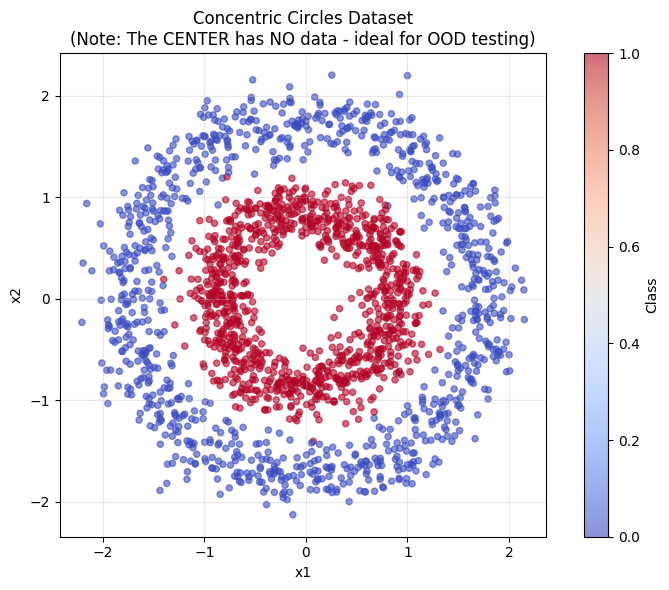

In [3]:
class CirclesDataset(Dataset):
    """
    Dataset for make_circles 2D classification.

    Returns:
        x: 2D point tensor
        y: Same as x (for reconstruction in Stage 0/1)
        class_label: Class label (0 or 1)
    """
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return {
            "x": self.X[idx],
            "y": self.X[idx],  # For reconstruction loss
            "class_label": self.y[idx]
        }


# Generate make_circles data
print("Generating make_circles data...")
N_SAMPLES = 2000
NOISE = 0.1  # Add some noise
FACTOR = 0.5  # Ratio of inner circle to outer circle

X, y = make_circles(n_samples=N_SAMPLES, noise=NOISE, factor=FACTOR, random_state=42)

# Standardize
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

train_dataset = CirclesDataset(X_train, y_train)
test_dataset = CirclesDataset(X_test, y_test)

print(f"  Train samples: {len(train_dataset)}")
print(f"  Test samples: {len(test_dataset)}")

# Visualize the data
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', alpha=0.6, s=20)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_title('Concentric Circles Dataset\n(Note: The CENTER has NO data - ideal for OOD testing)')
plt.colorbar(scatter, label='Class')
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

## 4. Build Systems

2つのモデルを構築します：
1. **Baseline MLP**: 通常のSoftmax分類器（過信する）
2. **Satipatthana**: Trust Scoreで不確実性を自覚する

In [4]:
# ========================================
# Baseline: Simple MLP Classifier
# ========================================
class BaselineMLP(nn.Module):
    """Simple MLP classifier with Softmax output."""

    def __init__(self, input_dim=2, hidden_dim=64, n_classes=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, n_classes)
        )

    def forward(self, x):
        return self.net(x)

    def predict_proba(self, x):
        """Return softmax probabilities."""
        logits = self.forward(x)
        return F.softmax(logits, dim=-1)


baseline_model = BaselineMLP(input_dim=INPUT_DIM, hidden_dim=64, n_classes=N_CLASSES)
baseline_model.to(device)
print("Baseline MLP created!")

Baseline MLP created!


In [5]:
# ========================================
# Satipatthana System
# ========================================
def build_satipatthana_system():
    """Build complete SatipatthanaSystem for 2D classification."""
    print("Building SatipatthanaSystem...")

    # Components
    adapter = IdentityAdapter(adapter_config)
    augmenter = GaussianNoiseAugmenter(augmenter_config)
    vitakka = StandardVitakka(vitakka_config)
    refiner = MlpRefiner({"dim": DIM})
    vicara = StandardVicara(vicara_config, refiner=refiner)
    sati = FixedStepSati(sati_config)
    vipassana_module = StandardVipassana(vipassana_config)
    task_decoder = ConditionalDecoder(task_decoder_config)

    # Reconstruction Heads
    adapter_recon_head = ReconstructionDecoder(adapter_recon_config)
    samatha_recon_head = ReconstructionDecoder(samatha_recon_config)

    # Engine Configs with strengthened drunk mode
    samatha_config_obj = SamathaConfig(
        dim=DIM,
        max_steps=MAX_STEPS,
        drunk_skip_prob=0.4,         # 40% chance to skip step (was 20%)
        drunk_perturbation_std=0.3,  # Larger perturbation (was 0.05)
        adapter=adapter_config,
        augmenter=augmenter_config,
        vitakka=vitakka_config,
        vicara=vicara_config,
        sati=sati_config
    )

    vipassana_engine_config = VipassanaEngineConfig(
        vipassana=vipassana_config
    )

    system_config = SystemConfig(
        dim=DIM,
        seed=42,
        use_label_guidance=True,
        samatha=samatha_config_obj,
        vipassana=vipassana_engine_config,
        task_decoder=task_decoder_config
    )

    # Engines
    samatha_engine = SamathaEngine(
        config=samatha_config_obj,
        adapter=adapter,
        augmenter=augmenter,
        vitakka=vitakka,
        vicara=vicara,
        sati=sati
    )

    vipassana_engine = VipassanaEngine(
        config=vipassana_engine_config,
        vipassana=vipassana_module
    )

    # System
    system = SatipatthanaSystem(
        config=system_config,
        samatha=samatha_engine,
        vipassana=vipassana_engine,
        task_decoder=task_decoder,
        adapter_recon_head=adapter_recon_head,
        samatha_recon_head=samatha_recon_head
    )

    print("  SatipatthanaSystem built successfully!")
    print(f"  Drunk mode: skip_prob={samatha_config_obj.drunk_skip_prob}, perturbation_std={samatha_config_obj.drunk_perturbation_std}")
    return system


system = build_satipatthana_system()
system.to(device)
print(f"  Moved to device: {device}")

Building SatipatthanaSystem...
  SatipatthanaSystem built successfully!
  Drunk mode: skip_prob=0.4, perturbation_std=0.3
  Moved to device: mps


## 5. Train Baseline MLP

まずBaselineの普通のMLPを学習します。

In [6]:
print("="*60)
print("Training Baseline MLP...")
print("="*60)

baseline_optimizer = torch.optim.Adam(baseline_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

BASELINE_EPOCHS = 50
losses = []

baseline_model.train()
for epoch in range(BASELINE_EPOCHS):
    epoch_loss = 0
    for batch in train_loader:
        x = batch["x"].to(device)
        y = batch["class_label"].to(device)

        baseline_optimizer.zero_grad()
        logits = baseline_model(x)
        loss = criterion(logits, y)
        loss.backward()
        baseline_optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)

    if (epoch + 1) % 10 == 0:
        print(f"  Epoch {epoch+1}/{BASELINE_EPOCHS}, Loss: {avg_loss:.4f}")

# Evaluate
baseline_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch in test_loader:
        x = batch["x"].to(device)
        y = batch["class_label"].to(device)
        logits = baseline_model(x)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

print(f"\nBaseline Test Accuracy: {correct/total*100:.2f}%")

Training Baseline MLP...
  Epoch 10/50, Loss: 0.0305
  Epoch 20/50, Loss: 0.0188
  Epoch 30/50, Loss: 0.0163
  Epoch 40/50, Loss: 0.0156
  Epoch 50/50, Loss: 0.0149

Baseline Test Accuracy: 99.50%


## 6. Train Satipatthana (4-Stage Curriculum)

Satipatthanaの4段階カリキュラム学習を実行します：
- **Stage 0**: Adapter Pre-training（入力→潜在空間の変換を学習）
- **Stage 1**: Samatha Training（収束する固定点を学習）
- **Stage 2**: Vipassana Training（メタ認知 - 信頼度の学習）
- **Stage 3**: Decoder Fine-tuning（最終タスク用デコーダの学習）

In [7]:
# ========================================
# Create VoidDataset for Stage 2
# ========================================
# Use FilteredNoiseVoid: samples noise that is FAR from training data
# This teaches Vipassana to recognize OOD inputs

train_data_tensor = torch.tensor(X_train, dtype=torch.float32)

void_dataset = FilteredNoiseVoid(
    reference_data=train_data_tensor,
    shape=(INPUT_DIM,),
    length=1000,  # Virtual dataset size
    min_distance=0.3,  # Must be at least 0.3 away from any training point
    noise_range=(-2.5, 2.5),  # Search range for OOD points
)

print(f"VoidDataset created with {len(void_dataset)} OOD samples")
print(f"  - Min distance from training data: 0.3")
print(f"  - Noise range: (-2.5, 2.5)")

# Verify a few samples
sample_void = void_dataset[0]["x"]
dists = torch.norm(train_data_tensor - sample_void, dim=1)
print(f"  - Sample void point distance to nearest training: {dists.min():.4f}")

# ========================================
# Create Trainer with VoidDataset
# ========================================
training_args = TrainingArguments(
    output_dir="./outputs/02_trust_score",
    num_train_epochs=1,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    logging_steps=100,
    remove_unused_columns=False,
    label_names=["y", "class_label"],
    report_to="none",
    save_strategy="no",
)

trainer = SatipatthanaTrainer(
    model=system,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    stage=TrainingStage.ADAPTER_PRETRAINING,
    task_type="classification",
    use_label_guidance=True,
    noise_level=0.3,
    stability_weight=0.05,
    guidance_weight=5.0,
    recon_weight=10.0,
    diversity_weight=0.5,
    label_key="class_label",  # 分類タスクではclass_labelを使用
    void_dataset=void_dataset,  # Stage 2で使用するOODデータ
)

print("\n" + "="*60)
print("Satipatthana 4-Stage Curriculum Training")
print("="*60)
print("  void_dataset: FilteredNoiseVoid (OOD points far from training data)")
print("  recon_error: Automatically computed from samatha_recon_head")

VoidDataset created with 1000 OOD samples
  - Min distance from training data: 0.3
  - Noise range: (-2.5, 2.5)
  - Sample void point distance to nearest training: 0.4703
[2025-12-12 01:53:54] INFO [satipatthana.core.system] Training stage set to: ADAPTER_PRETRAINING
[2025-12-12 01:53:54] INFO [satipatthana.train.trainer] Stage ADAPTER_PRETRAINING: Trainable components: ['adapter_recon_head']
[2025-12-12 01:53:54] INFO [satipatthana.train.trainer] Initialized SatipatthanaTrainer for stage: ADAPTER_PRETRAINING

Satipatthana 4-Stage Curriculum Training
  void_dataset: FilteredNoiseVoid (OOD points far from training data)
  recon_error: Automatically computed from samatha_recon_head


In [8]:
# Stage 0: Adapter Pre-training
print("\n--- Stage 0: Adapter Pre-training ---")
trainer.train_stage(TrainingStage.ADAPTER_PRETRAINING, num_epochs=5)


--- Stage 0: Adapter Pre-training ---
[2025-12-12 01:53:54] INFO [satipatthana.core.system] Training stage set to: ADAPTER_PRETRAINING
[2025-12-12 01:53:54] INFO [satipatthana.train.trainer] Stage ADAPTER_PRETRAINING: Trainable components: ['adapter_recon_head']
[2025-12-12 01:53:54] INFO [satipatthana.train.trainer] Starting ADAPTER_PRETRAINING training for 5 epochs


/Users/ryota.ido/mine/samadhi_model/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
100,1.107500


TrainOutput(global_step=125, training_loss=1.0665888061523439, metrics={'train_runtime': 0.4436, 'train_samples_per_second': 18032.891, 'train_steps_per_second': 281.764, 'total_flos': 0.0, 'train_loss': 1.0665888061523439, 'epoch': 5.0})

In [9]:
# Stage 1: Samatha Training
print("\n--- Stage 1: Samatha Training ---")
trainer.train_stage(TrainingStage.SAMATHA_TRAINING, num_epochs=15)


--- Stage 1: Samatha Training ---
[2025-12-12 01:53:54] INFO [satipatthana.core.system] Training stage set to: SAMATHA_TRAINING
[2025-12-12 01:53:54] INFO [satipatthana.train.trainer] Stage SAMATHA_TRAINING: Trainable components: ['vitakka', 'vicara', 'samatha_recon_head']
[2025-12-12 01:53:54] INFO [satipatthana.train.trainer] Starting SAMATHA_TRAINING training for 15 epochs


Step,Training Loss
100,10.857100
200,9.966500
300,9.955800


TrainOutput(global_step=375, training_loss=10.198781901041666, metrics={'train_runtime': 6.2817, 'train_samples_per_second': 3820.596, 'train_steps_per_second': 59.697, 'total_flos': 0.0, 'train_loss': 10.198781901041666, 'epoch': 15.0})

In [10]:
# Stage 2: Vipassana Training (重要！メタ認知の学習)
print("\n--- Stage 2: Vipassana Training ---")
print("  This stage teaches the model to recognize what it knows vs. doesn't know")
print("  Training with 5-way split: Clean, Augmented, Drunk, Mismatch, Void(OOD)")
print("  Void Path uses FilteredNoiseVoid: samples far from training data")
print("  Trust head uses 8 Grounding Metrics: velocity, avg_energy, convergence_steps,")
print("    min_dist, entropy, s0_min_dist, drift_magnitude, recon_error")
original_lr = trainer.args.learning_rate
trainer.args.learning_rate = 1e-2
trainer.train_stage(TrainingStage.VIPASSANA_TRAINING, num_epochs=20)
trainer.args.learning_rate = original_lr


--- Stage 2: Vipassana Training ---
  This stage teaches the model to recognize what it knows vs. doesn't know
  Training with 5-way split: Clean, Augmented, Drunk, Mismatch, Void(OOD)
  Void Path uses FilteredNoiseVoid: samples far from training data
  Trust head uses 8 Grounding Metrics: velocity, avg_energy, convergence_steps,
    min_dist, entropy, s0_min_dist, drift_magnitude, recon_error
[2025-12-12 01:54:02] INFO [satipatthana.train.trainer] Vipassana networks initialized via forward pass
[2025-12-12 01:54:02] INFO [satipatthana.core.system] Training stage set to: VIPASSANA_TRAINING
[2025-12-12 01:54:02] INFO [satipatthana.train.trainer] Stage VIPASSANA_TRAINING: Trainable components: ['vipassana']
[2025-12-12 01:54:02] INFO [satipatthana.train.trainer] Starting VIPASSANA_TRAINING training for 20 epochs


Step,Training Loss
100,1.805900
200,1.453700
300,1.212000
400,1.138900
500,1.094900


In [11]:
# Stage 2 Debug: Vipassanaの入力を確認（8 Grounding Metrics + Triple Score）
print("\n--- Stage 2: Debug - Checking Vipassana inputs (8 Grounding Metrics) ---")
print("Triple Score System: trust_score, conformity_score, confidence_score")

# Stage 2用にセット
system.set_stage(TrainingStage.VIPASSANA_TRAINING)

# テストデータで確認
test_batch = next(iter(train_loader))
x_test = test_batch["x"][:8].to(device)

print(f"Input shape: {x_test.shape}")

def compute_trajectory_features(result):
    """Vipassanaが見ている特徴量を計算"""
    santana = result['santana']
    s_star = result['s_star']

    # velocity
    initial_state = santana.get_initial_state()
    velocity = torch.norm(s_star - initial_state, dim=1)

    # avg_energy (per-sample)
    states = santana.to_tensor()
    state_diffs = states[1:] - states[:-1]
    per_sample_energy = (state_diffs ** 2).sum(dim=2).sum(dim=0)
    avg_energy = per_sample_energy / (len(santana) - 1)

    return velocity, avg_energy, initial_state

def print_triple_scores(result, label):
    """Triple Score を表示"""
    trust = result['trust_score'].squeeze()
    conformity = result['conformity_score'].squeeze()
    confidence = result['confidence_score'].squeeze()
    print(f"\n[{label}]")
    print(f"  Trust scores:      {[f'{t:.4f}' for t in trust.tolist()[:4]]}")
    print(f"  Conformity scores: {[f'{t:.4f}' for t in conformity.tolist()[:4]]}")
    print(f"  Confidence scores: {[f'{t:.4f}' for t in confidence.tolist()[:4]]}")

# 4つのパスを個別にテスト（+ Void Path）
with torch.no_grad():
    probes = system.samatha.vitakka.probes

    # 1. Clean path (no noise)
    result_clean = system.forward_stage2(x_test, noise_level=0.0, drunk_mode=False)
    vel_clean, energy_clean, s0_clean = compute_trajectory_features(result_clean)
    print_triple_scores(result_clean, "Clean Path")

    # 2. Augmented path (with noise)
    result_aug = system.forward_stage2(x_test, noise_level=0.7, drunk_mode=False)
    vel_aug, energy_aug, s0_aug = compute_trajectory_features(result_aug)
    print_triple_scores(result_aug, "Augmented Path (noise=0.7)")

    # 3. Drunk path
    result_drunk = system.forward_stage2(x_test, noise_level=0.0, drunk_mode=True)
    vel_drunk, energy_drunk, s0_drunk = compute_trajectory_features(result_drunk)
    print_triple_scores(result_drunk, "Drunk Path")

    # 4. Void Path (OOD data - using FilteredNoiseVoid)
    # Sample from our void_dataset to get genuine OOD points
    x_void = torch.stack([void_dataset[i]["x"] for i in range(8)]).to(device)
    result_void = system.forward_stage2(x_void, noise_level=0.0, drunk_mode=False)
    vel_void, energy_void, s0_void = compute_trajectory_features(result_void)
    print_triple_scores(result_void, "Void Path (OOD - from FilteredNoiseVoid)")

# 問題の診断 - Triple Score 比較
print(f"\n[Triple Score Comparison - Mean across batch]")
print(f"  {'Path':<12} {'Trust':<10} {'Conformity':<12} {'Confidence':<12}")
print(f"  {'-'*46}")
print(f"  {'Clean':<12} {result_clean['trust_score'].mean():.4f}     {result_clean['conformity_score'].mean():.4f}       {result_clean['confidence_score'].mean():.4f}")
print(f"  {'Augmented':<12} {result_aug['trust_score'].mean():.4f}     {result_aug['conformity_score'].mean():.4f}       {result_aug['confidence_score'].mean():.4f}")
print(f"  {'Drunk':<12} {result_drunk['trust_score'].mean():.4f}     {result_drunk['conformity_score'].mean():.4f}       {result_drunk['confidence_score'].mean():.4f}")
print(f"  {'Void(OOD)':<12} {result_void['trust_score'].mean():.4f}     {result_void['conformity_score'].mean():.4f}       {result_void['confidence_score'].mean():.4f}")

# OOD検出の確認
print(f"\n[OOD Detection Check - Using Trust Score]")
id_trust = result_clean['trust_score'].mean().item()
ood_trust = result_void['trust_score'].mean().item()
drunk_trust = result_drunk['trust_score'].mean().item()
print(f"  Clean (ID) Trust:  {id_trust:.4f}")
print(f"  Drunk Trust:       {drunk_trust:.4f}")
print(f"  Void (OOD) Trust:  {ood_trust:.4f}")
print(f"  ID - OOD diff:     {id_trust - ood_trust:.4f}")

if id_trust > ood_trust + 0.1:
    print("\n  ✓ OOD detection working! Trust Score differentiates ID from OOD.")
else:
    print("\n  ⚠️ OOD detection weak. May need more Stage 2 epochs.")


--- Stage 2: Debug - Checking Vipassana inputs (8 Grounding Metrics) ---
Triple Score System: trust_score, conformity_score, confidence_score
[2025-12-12 01:54:30] INFO [satipatthana.core.system] Training stage set to: VIPASSANA_TRAINING
Input shape: torch.Size([8, 2])

[Clean Path]
  Trust scores:      ['0.7174', '0.6874', '0.8048', '0.9242']
  Conformity scores: ['0.4858', '0.4242', '0.4858', '0.4572']
  Confidence scores: ['0.5439', '0.6193', '0.6327', '0.7152']

[Augmented Path (noise=0.7)]
  Trust scores:      ['0.7166', '0.4478', '0.7899', '0.7091']
  Conformity scores: ['0.4858', '0.3875', '0.4858', '0.3300']
  Confidence scores: ['0.6514', '0.3920', '0.6778', '0.5774']

[Drunk Path]
  Trust scores:      ['0.1254', '0.0084', '0.1513', '0.0229']
  Conformity scores: ['0.2905', '0.4288', '0.0174', '0.0637']
  Confidence scores: ['0.2195', '0.5271', '0.1547', '0.0381']

[Void Path (OOD - from FilteredNoiseVoid)]
  Trust scores:      ['0.0193', '0.0209', '0.1092', '0.0076']
  Confo

In [12]:
# Stage 3: Decoder Fine-tuning
print("\n--- Stage 3: Decoder Fine-tuning ---")
trainer.train_stage(TrainingStage.DECODER_FINETUNING, num_epochs=10)

# Set to inference mode
system.set_stage(TrainingStage.INFERENCE)
print("\n" + "="*60)
print("Training complete!")
print("="*60)


--- Stage 3: Decoder Fine-tuning ---
[2025-12-12 01:54:30] INFO [satipatthana.core.system] Training stage set to: DECODER_FINETUNING
[2025-12-12 01:54:30] INFO [satipatthana.train.trainer] Stage DECODER_FINETUNING: Trainable components: ['task_decoder']
[2025-12-12 01:54:30] INFO [satipatthana.train.trainer] Starting DECODER_FINETUNING training for 10 epochs


Step,Training Loss
100,0.710100
200,0.664400


[2025-12-12 01:54:33] INFO [satipatthana.core.system] Training stage set to: INFERENCE

Training complete!


## 7. Evaluate Satipatthana Accuracy

In [13]:
# Evaluate Satipatthana
system.eval()
correct = 0
total = 0

with torch.no_grad():
    for batch in test_loader:
        x = batch["x"].to(device)
        y = batch["class_label"].to(device)

        result = system(x, noise_level=0.0)
        # output is (batch, n_classes) with tanh activation [-1, 1]
        # Convert to class prediction
        preds = result.output.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

print(f"Satipatthana Test Accuracy: {correct/total*100:.2f}%")

Satipatthana Test Accuracy: 86.25%


## 8. Heatmap Visualization: Softmax vs Trust Score

これがこのNotebookのハイライトです！

空間全体にグリッド点を配置し、各点での：
1. **Softmax確率（最大値）**: Baseline MLPの「自信度」
2. **Trust Score**: Satipatthanaの「自信度」

を可視化します。

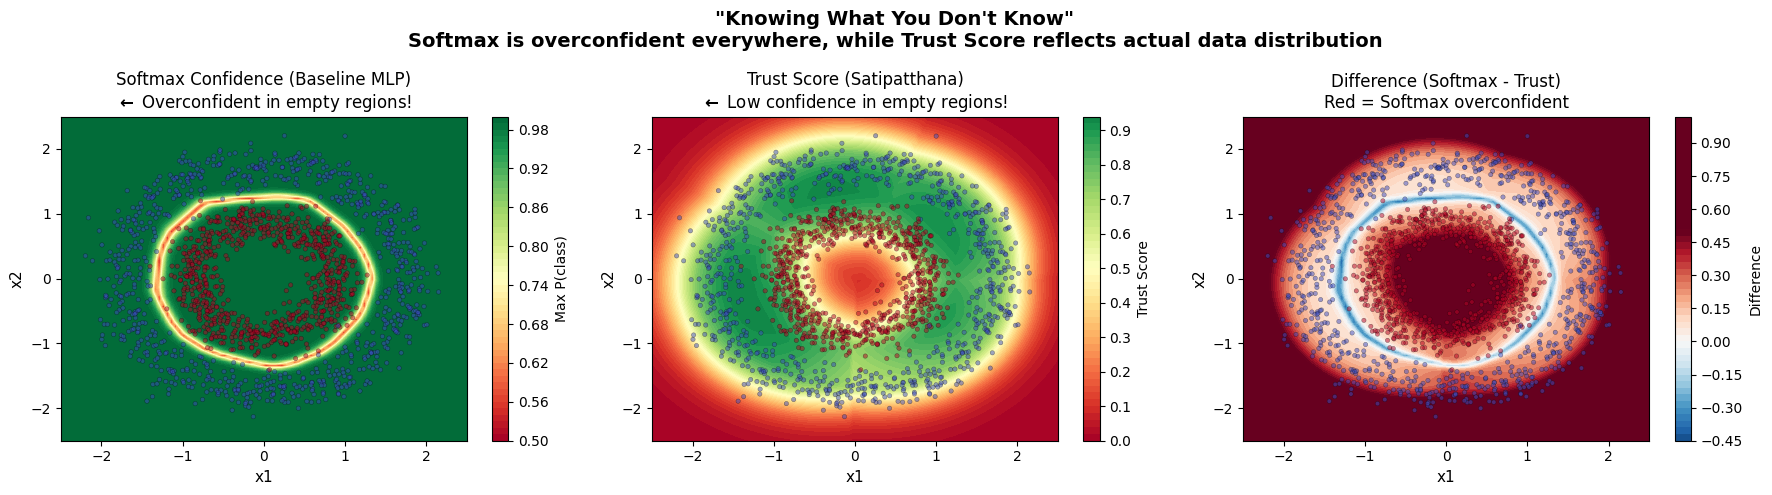

In [14]:
def create_heatmap_comparison(baseline_model, satipatthana_system, X_train, y_train,
                               grid_range=(-2.5, 2.5), grid_resolution=100):
    """
    Create side-by-side heatmaps comparing Softmax confidence vs Trust Score.

    Args:
        baseline_model: Trained baseline MLP
        satipatthana_system: Trained Satipatthana system
        X_train: Training data points (for overlay)
        y_train: Training labels
        grid_range: Range for grid points
        grid_resolution: Number of points per axis
    """
    baseline_model.eval()
    satipatthana_system.eval()

    # Create grid
    x1 = np.linspace(grid_range[0], grid_range[1], grid_resolution)
    x2 = np.linspace(grid_range[0], grid_range[1], grid_resolution)
    X1, X2 = np.meshgrid(x1, x2)
    grid_points = np.column_stack([X1.ravel(), X2.ravel()])
    grid_tensor = torch.tensor(grid_points, dtype=torch.float32).to(device)

    # Get predictions in batches
    batch_size = 500
    n_points = len(grid_points)

    softmax_confidence = []
    trust_scores = []
    softmax_preds = []
    satipatthana_preds = []

    with torch.no_grad():
        for i in range(0, n_points, batch_size):
            batch = grid_tensor[i:i+batch_size]

            # Baseline: Softmax confidence (max probability)
            probs = baseline_model.predict_proba(batch)
            max_prob, pred = probs.max(dim=1)
            softmax_confidence.extend(max_prob.cpu().numpy())
            softmax_preds.extend(pred.cpu().numpy())

            # Satipatthana: Trust score
            result = satipatthana_system(batch, noise_level=0.0)
            trust_scores.extend(result.trust_score.squeeze().cpu().numpy())
            sati_pred = result.output.argmax(dim=1)
            satipatthana_preds.extend(sati_pred.cpu().numpy())

    softmax_confidence = np.array(softmax_confidence).reshape(grid_resolution, grid_resolution)
    trust_scores = np.array(trust_scores).reshape(grid_resolution, grid_resolution)
    softmax_preds = np.array(softmax_preds).reshape(grid_resolution, grid_resolution)
    satipatthana_preds = np.array(satipatthana_preds).reshape(grid_resolution, grid_resolution)

    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Plot A: Softmax Confidence
    im1 = axes[0].contourf(X1, X2, softmax_confidence, levels=50, cmap='RdYlGn', vmin=0.5, vmax=1.0)
    axes[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='coolwarm',
                    alpha=0.5, s=10, edgecolors='k', linewidths=0.3)
    axes[0].set_xlabel('x1', fontsize=11)
    axes[0].set_ylabel('x2', fontsize=11)
    axes[0].set_title('Softmax Confidence (Baseline MLP)\n' +
                      r'$\mathbf{\leftarrow}$ Overconfident in empty regions!', fontsize=12)
    plt.colorbar(im1, ax=axes[0], label='Max P(class)')

    # Plot B: Trust Score
    im2 = axes[1].contourf(X1, X2, trust_scores, levels=50, cmap='RdYlGn', vmin=0.0, vmax=1.0)
    axes[1].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='coolwarm',
                    alpha=0.5, s=10, edgecolors='k', linewidths=0.3)
    axes[1].set_xlabel('x1', fontsize=11)
    axes[1].set_ylabel('x2', fontsize=11)
    axes[1].set_title('Trust Score (Satipatthana)\n' +
                      r'$\mathbf{\leftarrow}$ Low confidence in empty regions!', fontsize=12)
    plt.colorbar(im2, ax=axes[1], label='Trust Score')

    # Plot C: Difference (Softmax - Trust)
    diff = softmax_confidence - trust_scores
    im3 = axes[2].contourf(X1, X2, diff, levels=50, cmap='RdBu_r', vmin=-0.5, vmax=0.5)
    axes[2].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='coolwarm',
                    alpha=0.5, s=10, edgecolors='k', linewidths=0.3)
    axes[2].set_xlabel('x1', fontsize=11)
    axes[2].set_ylabel('x2', fontsize=11)
    axes[2].set_title('Difference (Softmax - Trust)\n' +
                      'Red = Softmax overconfident', fontsize=12)
    plt.colorbar(im3, ax=axes[2], label='Difference')

    plt.suptitle('"Knowing What You Don\'t Know"\n' +
                 'Softmax is overconfident everywhere, while Trust Score reflects actual data distribution',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    return softmax_confidence, trust_scores


# Create the comparison heatmaps
softmax_conf, trust_conf = create_heatmap_comparison(
    baseline_model, system, X_train, y_train
)

## 9. Decision Boundary Comparison

決定境界と信頼度の関係を可視化します。

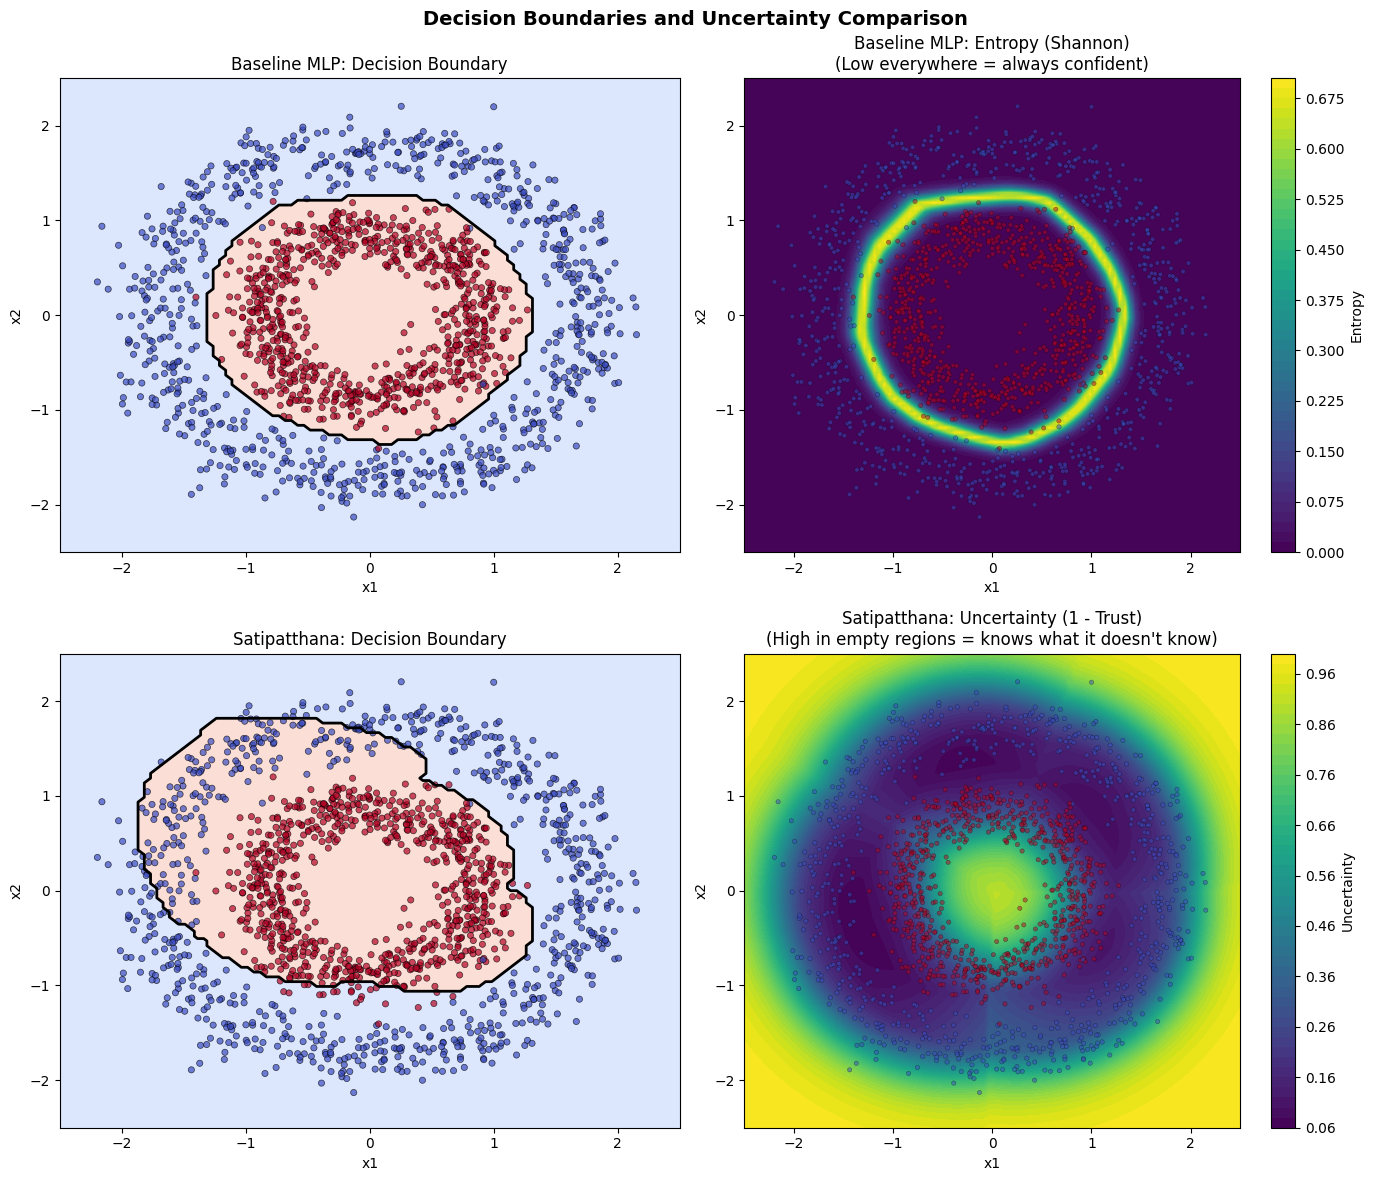

In [15]:
def visualize_decision_boundaries(baseline_model, satipatthana_system, X_train, y_train,
                                   grid_range=(-2.5, 2.5), grid_resolution=100):
    """
    Visualize decision boundaries for both models.
    """
    baseline_model.eval()
    satipatthana_system.eval()

    # Create grid
    x1 = np.linspace(grid_range[0], grid_range[1], grid_resolution)
    x2 = np.linspace(grid_range[0], grid_range[1], grid_resolution)
    X1, X2 = np.meshgrid(x1, x2)
    grid_points = np.column_stack([X1.ravel(), X2.ravel()])
    grid_tensor = torch.tensor(grid_points, dtype=torch.float32).to(device)

    # Get predictions
    with torch.no_grad():
        # Baseline
        baseline_probs = baseline_model.predict_proba(grid_tensor)
        baseline_preds = baseline_probs.argmax(dim=1).cpu().numpy()
        baseline_entropy = -(baseline_probs * torch.log(baseline_probs + 1e-8)).sum(dim=1).cpu().numpy()

        # Satipatthana
        result = satipatthana_system(grid_tensor, noise_level=0.0)
        sati_preds = result.output.argmax(dim=1).cpu().numpy()
        trust_scores = result.trust_score.squeeze().cpu().numpy()

    baseline_preds = baseline_preds.reshape(grid_resolution, grid_resolution)
    baseline_entropy = baseline_entropy.reshape(grid_resolution, grid_resolution)
    sati_preds = sati_preds.reshape(grid_resolution, grid_resolution)
    trust_scores = trust_scores.reshape(grid_resolution, grid_resolution)

    # Create figure
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))

    # Plot 1: Baseline Decision Boundary
    axes[0, 0].contourf(X1, X2, baseline_preds, levels=1, cmap='coolwarm', alpha=0.3)
    axes[0, 0].contour(X1, X2, baseline_preds, levels=[0.5], colors='black', linewidths=2)
    axes[0, 0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='coolwarm',
                       alpha=0.7, s=20, edgecolors='k', linewidths=0.5)
    axes[0, 0].set_xlabel('x1')
    axes[0, 0].set_ylabel('x2')
    axes[0, 0].set_title('Baseline MLP: Decision Boundary')

    # Plot 2: Baseline Entropy (uncertainty)
    im2 = axes[0, 1].contourf(X1, X2, baseline_entropy, levels=50, cmap='viridis')
    axes[0, 1].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='coolwarm',
                       alpha=0.5, s=10, edgecolors='k', linewidths=0.3)
    axes[0, 1].set_xlabel('x1')
    axes[0, 1].set_ylabel('x2')
    axes[0, 1].set_title('Baseline MLP: Entropy (Shannon)\n(Low everywhere = always confident)')
    plt.colorbar(im2, ax=axes[0, 1], label='Entropy')

    # Plot 3: Satipatthana Decision Boundary
    axes[1, 0].contourf(X1, X2, sati_preds, levels=1, cmap='coolwarm', alpha=0.3)
    axes[1, 0].contour(X1, X2, sati_preds, levels=[0.5], colors='black', linewidths=2)
    axes[1, 0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='coolwarm',
                       alpha=0.7, s=20, edgecolors='k', linewidths=0.5)
    axes[1, 0].set_xlabel('x1')
    axes[1, 0].set_ylabel('x2')
    axes[1, 0].set_title('Satipatthana: Decision Boundary')

    # Plot 4: Trust Score (uncertainty)
    im4 = axes[1, 1].contourf(X1, X2, 1 - trust_scores, levels=50, cmap='viridis')
    axes[1, 1].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='coolwarm',
                       alpha=0.5, s=10, edgecolors='k', linewidths=0.3)
    axes[1, 1].set_xlabel('x1')
    axes[1, 1].set_ylabel('x2')
    axes[1, 1].set_title('Satipatthana: Uncertainty (1 - Trust)\n(High in empty regions = knows what it doesn\'t know)')
    plt.colorbar(im4, ax=axes[1, 1], label='Uncertainty')

    plt.suptitle('Decision Boundaries and Uncertainty Comparison', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


# Visualize decision boundaries
visualize_decision_boundaries(baseline_model, system, X_train, y_train)

## 10. Trust Score Distribution Analysis

データ点と空白地帯での Trust Score の分布を比較します。

/var/folders/c_/t1qgbjhx53d0vkb8gswlx5cw0000gq/T/ipykernel_17851/2853859821.py:60: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1].boxplot(box_data, labels=['Test Data\n(ID)', 'Random Points\n(OOD)'],


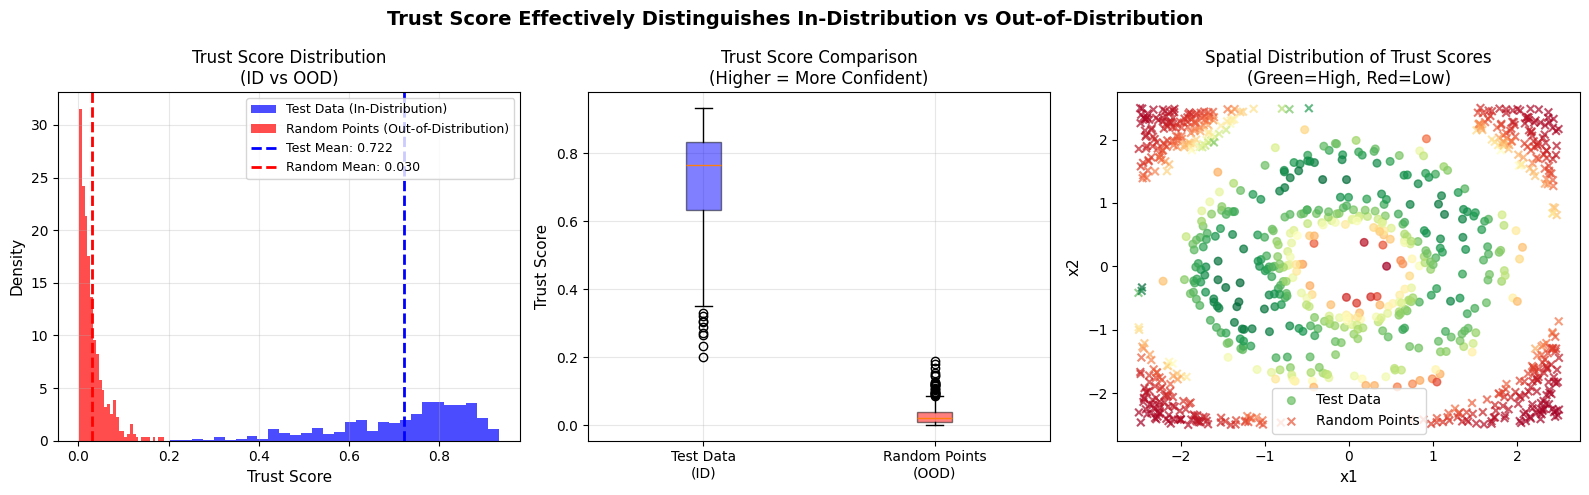


--- Trust Score Statistics ---
Test Data (In-Distribution):
  Mean: 0.7217, Std: 0.1501
  Min: 0.2021, Max: 0.9340

Random Points (Out-of-Distribution):
  Mean: 0.0299, Std: 0.0296
  Min: 0.0010, Max: 0.1894

Separation (ID mean - OOD mean): 0.6917


In [16]:
def analyze_trust_distribution(satipatthana_system, X_test, y_test,
                                grid_range=(-2.5, 2.5), n_random=500):
    """
    Compare Trust Score distribution for:
    1. Test data points (in-distribution)
    2. Random points from empty regions (out-of-distribution)
    """
    satipatthana_system.eval()

    # Get trust scores for test data
    test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    with torch.no_grad():
        result = satipatthana_system(test_tensor, noise_level=0.0)
        test_trust = result.trust_score.squeeze().cpu().numpy()

    # Generate random points in empty regions
    # (points far from any training data)
    np.random.seed(42)
    random_points = []
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)

    while len(random_points) < n_random:
        # Generate candidate points
        candidates = np.random.uniform(grid_range[0], grid_range[1], (1000, 2))
        candidates_tensor = torch.tensor(candidates, dtype=torch.float32)

        # Calculate distance to nearest training point
        for cand in candidates_tensor:
            dists = torch.norm(X_train_tensor - cand, dim=1)
            min_dist = dists.min().item()
            # Keep points that are far from training data
            if min_dist > 0.5:  # Distance threshold
                random_points.append(cand.numpy())
                if len(random_points) >= n_random:
                    break

    random_points = np.array(random_points[:n_random])
    random_tensor = torch.tensor(random_points, dtype=torch.float32).to(device)

    with torch.no_grad():
        result = satipatthana_system(random_tensor, noise_level=0.0)
        random_trust = result.trust_score.squeeze().cpu().numpy()

    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))

    # Plot 1: Histogram comparison
    axes[0].hist(test_trust, bins=30, alpha=0.7, label='Test Data (In-Distribution)', color='blue', density=True)
    axes[0].hist(random_trust, bins=30, alpha=0.7, label='Random Points (Out-of-Distribution)', color='red', density=True)
    axes[0].axvline(x=test_trust.mean(), color='blue', linestyle='--', linewidth=2, label=f'Test Mean: {test_trust.mean():.3f}')
    axes[0].axvline(x=random_trust.mean(), color='red', linestyle='--', linewidth=2, label=f'Random Mean: {random_trust.mean():.3f}')
    axes[0].set_xlabel('Trust Score', fontsize=11)
    axes[0].set_ylabel('Density', fontsize=11)
    axes[0].set_title('Trust Score Distribution\n(ID vs OOD)', fontsize=12)
    axes[0].legend(fontsize=9)
    axes[0].grid(True, alpha=0.3)

    # Plot 2: Box plot
    box_data = [test_trust, random_trust]
    bp = axes[1].boxplot(box_data, labels=['Test Data\n(ID)', 'Random Points\n(OOD)'],
                          patch_artist=True)
    bp['boxes'][0].set_facecolor('blue')
    bp['boxes'][0].set_alpha(0.5)
    bp['boxes'][1].set_facecolor('red')
    bp['boxes'][1].set_alpha(0.5)
    axes[1].set_ylabel('Trust Score', fontsize=11)
    axes[1].set_title('Trust Score Comparison\n(Higher = More Confident)', fontsize=12)
    axes[1].grid(True, alpha=0.3)

    # Plot 3: Spatial visualization
    axes[2].scatter(X_test[:, 0], X_test[:, 1], c=test_trust, cmap='RdYlGn',
                    s=30, alpha=0.7, label='Test Data')
    axes[2].scatter(random_points[:, 0], random_points[:, 1], c=random_trust, cmap='RdYlGn',
                    s=30, alpha=0.7, marker='x', label='Random Points')
    axes[2].set_xlabel('x1', fontsize=11)
    axes[2].set_ylabel('x2', fontsize=11)
    axes[2].set_title('Spatial Distribution of Trust Scores\n(Green=High, Red=Low)', fontsize=12)
    axes[2].legend()

    plt.suptitle('Trust Score Effectively Distinguishes In-Distribution vs Out-of-Distribution',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Print statistics
    print("\n--- Trust Score Statistics ---")
    print(f"Test Data (In-Distribution):")
    print(f"  Mean: {test_trust.mean():.4f}, Std: {test_trust.std():.4f}")
    print(f"  Min: {test_trust.min():.4f}, Max: {test_trust.max():.4f}")
    print(f"\nRandom Points (Out-of-Distribution):")
    print(f"  Mean: {random_trust.mean():.4f}, Std: {random_trust.std():.4f}")
    print(f"  Min: {random_trust.min():.4f}, Max: {random_trust.max():.4f}")

    # Separation quality
    separation = test_trust.mean() - random_trust.mean()
    print(f"\nSeparation (ID mean - OOD mean): {separation:.4f}")


# Analyze trust distribution
analyze_trust_distribution(system, X_test, y_test)

## 11. Convergence Trajectory Analysis

In-Distribution点とOut-of-Distribution点での収束パターンの違いを可視化します。

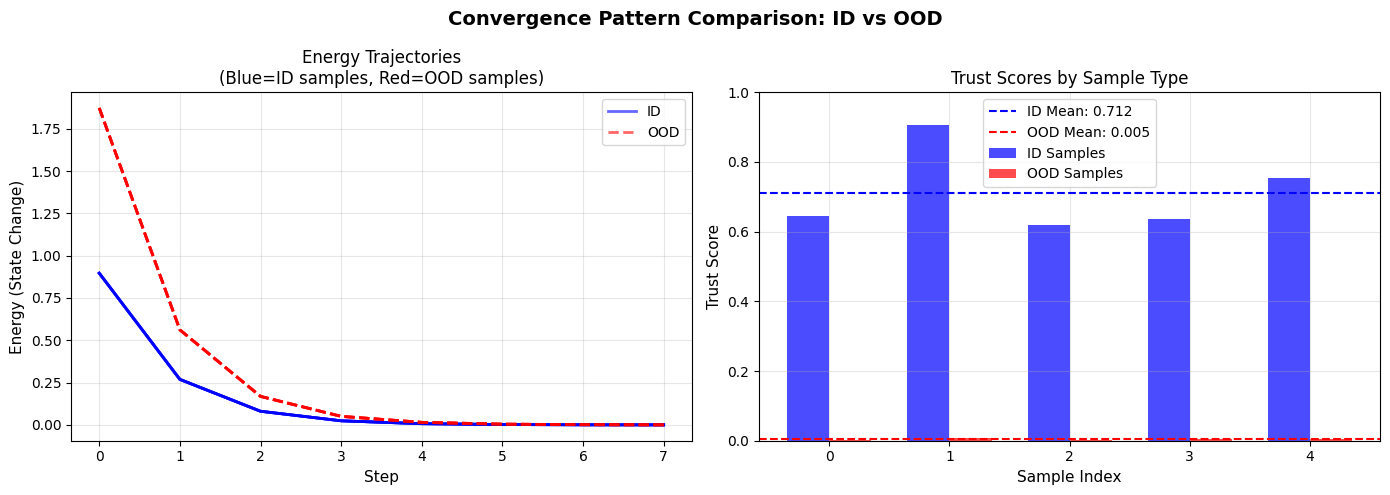

In [17]:
def visualize_convergence_patterns(satipatthana_system, X_test, X_train,
                                    n_id_samples=5, n_ood_samples=5):
    """
    Compare convergence patterns for ID vs OOD samples.
    """
    satipatthana_system.eval()

    # Select ID samples (from test data)
    id_indices = np.random.choice(len(X_test), n_id_samples, replace=False)
    id_samples = torch.tensor(X_test[id_indices], dtype=torch.float32).to(device)

    # Generate OOD samples (far from training data)
    np.random.seed(123)
    ood_samples = []
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)

    while len(ood_samples) < n_ood_samples:
        candidate = np.random.uniform(-2.5, 2.5, (1, 2))
        dists = torch.norm(X_train_tensor - torch.tensor(candidate, dtype=torch.float32), dim=1)
        if dists.min().item() > 0.8:  # Far from training data
            ood_samples.append(candidate[0])

    ood_samples = torch.tensor(np.array(ood_samples), dtype=torch.float32).to(device)

    # Get convergence trajectories
    with torch.no_grad():
        id_result = satipatthana_system(id_samples, noise_level=0.0)
        ood_result = satipatthana_system(ood_samples, noise_level=0.0)

    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot 1: Energy trajectories
    for i in range(n_id_samples):
        energies = id_result.santana.energies
        axes[0].plot(energies, 'b-', alpha=0.6, linewidth=2, label='ID' if i == 0 else '')

    for i in range(n_ood_samples):
        energies = ood_result.santana.energies
        axes[0].plot(energies, 'r--', alpha=0.6, linewidth=2, label='OOD' if i == 0 else '')

    axes[0].set_xlabel('Step', fontsize=11)
    axes[0].set_ylabel('Energy (State Change)', fontsize=11)
    axes[0].set_title('Energy Trajectories\n(Blue=ID samples, Red=OOD samples)', fontsize=12)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Plot 2: Trust scores comparison
    id_trust = id_result.trust_score.squeeze().cpu().numpy()
    ood_trust = ood_result.trust_score.squeeze().cpu().numpy()

    x_pos = np.arange(max(n_id_samples, n_ood_samples))
    width = 0.35

    axes[1].bar(x_pos[:n_id_samples] - width/2, id_trust, width, label='ID Samples', color='blue', alpha=0.7)
    axes[1].bar(x_pos[:n_ood_samples] + width/2, ood_trust, width, label='OOD Samples', color='red', alpha=0.7)
    axes[1].axhline(y=id_trust.mean(), color='blue', linestyle='--', label=f'ID Mean: {id_trust.mean():.3f}')
    axes[1].axhline(y=ood_trust.mean(), color='red', linestyle='--', label=f'OOD Mean: {ood_trust.mean():.3f}')
    axes[1].set_xlabel('Sample Index', fontsize=11)
    axes[1].set_ylabel('Trust Score', fontsize=11)
    axes[1].set_title('Trust Scores by Sample Type', fontsize=12)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    axes[1].set_ylim(0, 1)

    plt.suptitle('Convergence Pattern Comparison: ID vs OOD', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


# Visualize convergence patterns
visualize_convergence_patterns(system, X_test, X_train)

## 12. Latent Trajectory Visualization (Advanced)

**アーキテクトからの提案**: 低信頼度領域で「思考」がどのように動いているかを可視化します。

高信頼度領域（データ付近）では潜在状態 $S_t$ が「一直線」にアトラクタへ収束するのに対し、
低信頼度領域（空白地帯）では「振動」「徘徊」といった不安定な挙動が観測されるはずです。

これがVipassanaが「自信がない」と判断する根拠となります。

/var/folders/c_/t1qgbjhx53d0vkb8gswlx5cw0000gq/T/ipykernel_17851/2919542839.py:98: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax1.scatter(pt[0], pt[1], c=color, s=150, marker=marker, edgecolors='black', linewidths=2,
/var/folders/c_/t1qgbjhx53d0vkb8gswlx5cw0000gq/T/ipykernel_17851/2919542839.py:249: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(all_smoothness, all_trust_scores, 1)


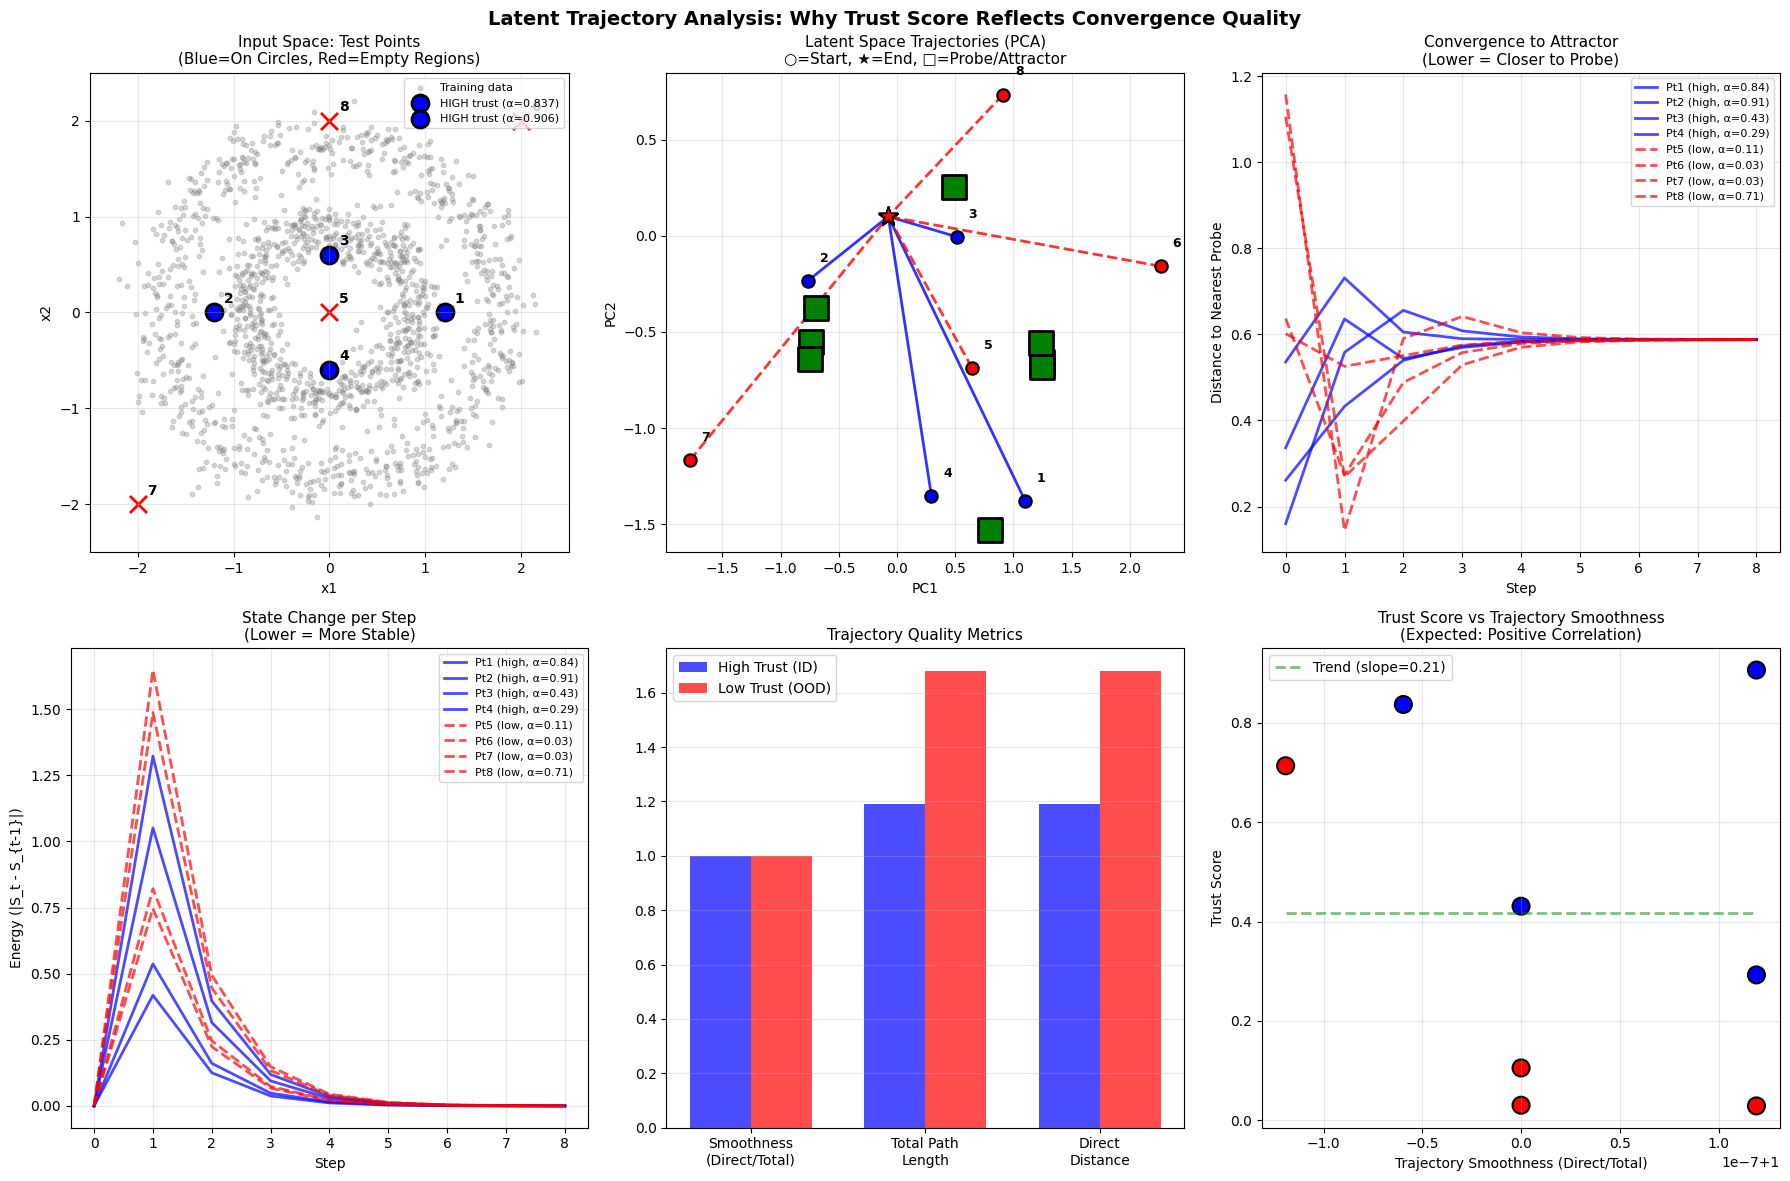


TRAJECTORY ANALYSIS SUMMARY

Point    Region       Trust      Smoothness   Path Length 
------------------------------------------------------
1        HIGH         0.8370     1.0000       1.8890      
2        HIGH         0.9064     1.0000       0.7671      
3        HIGH         0.4308     1.0000       0.5977      
4        HIGH         0.2925     1.0000       1.5010      
5        LOW          0.1051     1.0000       1.0660      
6        LOW          0.0300     1.0000       2.3538      
7        LOW          0.0286     1.0000       2.1244      
8        LOW          0.7136     1.0000       1.1727      

INSIGHT:
----------------------------------------------------------------------
  High-trust points avg smoothness: 1.0000
  Low-trust points avg smoothness:  1.0000
  Smoothness ratio (High/Low):      1.00x

  → High-trust trajectories are 1.0x more direct
  → Low-trust trajectories show more 'wandering' behavior


In [18]:
from sklearn.decomposition import PCA

def visualize_latent_trajectories_detailed(satipatthana_system, X_train,
                                            high_trust_points=None, low_trust_points=None):
    """
    Visualize latent state trajectories S_0 -> S_1 -> ... -> S* in 2D using PCA.

    Compare trajectories from:
    1. High-trust regions (near training data) - expect smooth, direct convergence
    2. Low-trust regions (empty space) - expect wandering, oscillation

    Args:
        satipatthana_system: Trained system
        X_train: Training data for reference
        high_trust_points: Optional list of (x1, x2) points in high-trust regions
        low_trust_points: Optional list of (x1, x2) points in low-trust regions
    """
    satipatthana_system.eval()

    # Default test points for concentric circles dataset
    if high_trust_points is None:
        # Points on the circles (high trust expected)
        high_trust_points = [
            (1.2, 0.0),    # On outer circle (right)
            (-1.2, 0.0),   # On outer circle (left)
            (0.0, 0.6),    # On inner circle (top)
            (0.0, -0.6),   # On inner circle (bottom)
        ]

    if low_trust_points is None:
        # Points in empty regions (low trust expected)
        low_trust_points = [
            (0.0, 0.0),    # CENTER - no data here!
            (2.0, 2.0),    # Far corner
            (-2.0, -2.0),  # Far corner
            (0.0, 2.0),    # Outside circles
        ]

    # Collect all trajectories
    all_trajectories = []
    all_labels = []  # 'high' or 'low'
    all_trust_scores = []
    all_points = []

    for pt in high_trust_points:
        pt_tensor = torch.tensor([[pt[0], pt[1]]], dtype=torch.float32).to(device)
        with torch.no_grad():
            result = satipatthana_system(pt_tensor, noise_level=0.0)
            trajectory = result.santana.to_tensor()  # (steps, 1, dim)
            trajectory = trajectory[:, 0, :].cpu().numpy()  # (steps, dim)
        all_trajectories.append(trajectory)
        all_labels.append('high')
        all_trust_scores.append(result.trust_score.item())
        all_points.append(pt)

    for pt in low_trust_points:
        pt_tensor = torch.tensor([[pt[0], pt[1]]], dtype=torch.float32).to(device)
        with torch.no_grad():
            result = satipatthana_system(pt_tensor, noise_level=0.0)
            trajectory = result.santana.to_tensor()  # (steps, 1, dim)
            trajectory = trajectory[:, 0, :].cpu().numpy()  # (steps, dim)
        all_trajectories.append(trajectory)
        all_labels.append('low')
        all_trust_scores.append(result.trust_score.item())
        all_points.append(pt)

    # Fit PCA on all trajectory points
    all_states = np.vstack(all_trajectories)
    pca = PCA(n_components=2)
    all_states_2d = pca.fit_transform(all_states)

    # Also project probes (attractors)
    with torch.no_grad():
        probes = satipatthana_system.samatha.vitakka.probes.data.cpu().numpy()
    probes_2d = pca.transform(probes)

    # Split back into trajectories
    idx = 0
    trajectories_2d = []
    for traj in all_trajectories:
        n_steps = len(traj)
        traj_2d = all_states_2d[idx:idx + n_steps]
        trajectories_2d.append(traj_2d)
        idx += n_steps

    # Create figure with multiple subplots
    fig = plt.figure(figsize=(18, 12))

    # ============================================
    # Plot 1: Input space with test points marked
    # ============================================
    ax1 = fig.add_subplot(2, 3, 1)
    ax1.scatter(X_train[:, 0], X_train[:, 1], c='gray', alpha=0.3, s=10, label='Training data')

    for i, (pt, label, trust) in enumerate(zip(all_points, all_labels, all_trust_scores)):
        color = 'blue' if label == 'high' else 'red'
        marker = 'o' if label == 'high' else 'x'
        ax1.scatter(pt[0], pt[1], c=color, s=150, marker=marker, edgecolors='black', linewidths=2,
                   label=f'{label.upper()} trust (α={trust:.3f})' if i < 2 else '')
        ax1.annotate(f'{i+1}', (pt[0]+0.1, pt[1]+0.1), fontsize=10, fontweight='bold')

    ax1.set_xlabel('x1')
    ax1.set_ylabel('x2')
    ax1.set_title('Input Space: Test Points\n(Blue=On Circles, Red=Empty Regions)', fontsize=11)
    ax1.legend(loc='upper right', fontsize=8)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(-2.5, 2.5)
    ax1.set_ylim(-2.5, 2.5)
    ax1.set_aspect('equal')

    # ============================================
    # Plot 2: All trajectories in latent space
    # ============================================
    ax2 = fig.add_subplot(2, 3, 2)

    for i, (traj_2d, label, trust) in enumerate(zip(trajectories_2d, all_labels, all_trust_scores)):
        color = 'blue' if label == 'high' else 'red'
        alpha = 0.8 if label == 'high' else 0.8
        linestyle = '-' if label == 'high' else '--'

        # Plot trajectory
        ax2.plot(traj_2d[:, 0], traj_2d[:, 1], linestyle, color=color, alpha=alpha, linewidth=2)
        # Mark start (circle) and end (star)
        ax2.scatter(traj_2d[0, 0], traj_2d[0, 1], c=color, marker='o', s=80, edgecolors='black', linewidths=1.5, zorder=5)
        ax2.scatter(traj_2d[-1, 0], traj_2d[-1, 1], c=color, marker='*', s=200, edgecolors='black', linewidths=1, zorder=5)
        # Add index label
        ax2.annotate(f'{i+1}', (traj_2d[0, 0]+0.1, traj_2d[0, 1]+0.1), fontsize=9, fontweight='bold')

    # Plot probes (attractors)
    for j in range(len(probes_2d)):
        ax2.scatter(probes_2d[j, 0], probes_2d[j, 1], c='green', marker='s', s=300,
                   edgecolors='black', linewidths=2, zorder=10)
        ax2.annotate(f'P{j}', (probes_2d[j, 0], probes_2d[j, 1]), fontsize=10,
                    fontweight='bold', ha='center', va='center', color='white')

    ax2.set_xlabel('PC1')
    ax2.set_ylabel('PC2')
    ax2.set_title('Latent Space Trajectories (PCA)\n○=Start, ★=End, □=Probe/Attractor', fontsize=11)
    ax2.grid(True, alpha=0.3)

    # ============================================
    # Plot 3: Step-by-step distance from probes
    # ============================================
    ax3 = fig.add_subplot(2, 3, 3)

    for i, (traj, label, trust) in enumerate(zip(all_trajectories, all_labels, all_trust_scores)):
        color = 'blue' if label == 'high' else 'red'
        linestyle = '-' if label == 'high' else '--'

        # Compute distance to nearest probe at each step
        distances = []
        for state in traj:
            dists_to_probes = np.linalg.norm(probes - state, axis=1)
            distances.append(dists_to_probes.min())

        ax3.plot(distances, linestyle, color=color, alpha=0.7, linewidth=2,
                label=f'Pt{i+1} ({label}, α={trust:.2f})')

    ax3.set_xlabel('Step')
    ax3.set_ylabel('Distance to Nearest Probe')
    ax3.set_title('Convergence to Attractor\n(Lower = Closer to Probe)', fontsize=11)
    ax3.legend(fontsize=8, loc='upper right')
    ax3.grid(True, alpha=0.3)

    # ============================================
    # Plot 4: Energy (state change) per step
    # ============================================
    ax4 = fig.add_subplot(2, 3, 4)

    for i, (traj, label, trust) in enumerate(zip(all_trajectories, all_labels, all_trust_scores)):
        color = 'blue' if label == 'high' else 'red'
        linestyle = '-' if label == 'high' else '--'

        # Compute state change (energy) at each step
        energies = [0]  # First step has no previous state
        for t in range(1, len(traj)):
            energy = np.linalg.norm(traj[t] - traj[t-1])
            energies.append(energy)

        ax4.plot(energies, linestyle, color=color, alpha=0.7, linewidth=2,
                label=f'Pt{i+1} ({label}, α={trust:.2f})')

    ax4.set_xlabel('Step')
    ax4.set_ylabel('Energy (|S_t - S_{t-1}|)')
    ax4.set_title('State Change per Step\n(Lower = More Stable)', fontsize=11)
    ax4.legend(fontsize=8, loc='upper right')
    ax4.grid(True, alpha=0.3)

    # ============================================
    # Plot 5: Trajectory smoothness analysis
    # ============================================
    ax5 = fig.add_subplot(2, 3, 5)

    # Compute trajectory metrics
    smoothness_data = {'high': [], 'low': []}
    total_length_data = {'high': [], 'low': []}
    direct_dist_data = {'high': [], 'low': []}

    for traj, label in zip(all_trajectories, all_labels):
        # Total path length
        total_length = sum(np.linalg.norm(traj[t] - traj[t-1]) for t in range(1, len(traj)))
        # Direct distance (start to end)
        direct_dist = np.linalg.norm(traj[-1] - traj[0])
        # Smoothness ratio (lower = more wandering)
        smoothness = direct_dist / (total_length + 1e-8)

        smoothness_data[label].append(smoothness)
        total_length_data[label].append(total_length)
        direct_dist_data[label].append(direct_dist)

    # Bar chart
    x = np.arange(3)
    width = 0.35

    high_means = [np.mean(smoothness_data['high']),
                  np.mean(total_length_data['high']),
                  np.mean(direct_dist_data['high'])]
    low_means = [np.mean(smoothness_data['low']),
                 np.mean(total_length_data['low']),
                 np.mean(direct_dist_data['low'])]

    ax5.bar(x - width/2, high_means, width, label='High Trust (ID)', color='blue', alpha=0.7)
    ax5.bar(x + width/2, low_means, width, label='Low Trust (OOD)', color='red', alpha=0.7)
    ax5.set_xticks(x)
    ax5.set_xticklabels(['Smoothness\n(Direct/Total)', 'Total Path\nLength', 'Direct\nDistance'])
    ax5.set_title('Trajectory Quality Metrics', fontsize=11)
    ax5.legend()
    ax5.grid(True, alpha=0.3, axis='y')

    # ============================================
    # Plot 6: Trust Score vs Smoothness scatter
    # ============================================
    ax6 = fig.add_subplot(2, 3, 6)

    all_smoothness = smoothness_data['high'] + smoothness_data['low']
    colors = ['blue'] * len(smoothness_data['high']) + ['red'] * len(smoothness_data['low'])

    ax6.scatter(all_smoothness, all_trust_scores, c=colors, s=150, edgecolors='black', linewidths=1.5)

    for i, (s, t) in enumerate(zip(all_smoothness, all_trust_scores)):
        ax6.annotate(f'{i+1}', (s+0.02, t+0.02), fontsize=9, fontweight='bold')

    ax6.set_xlabel('Trajectory Smoothness (Direct/Total)')
    ax6.set_ylabel('Trust Score')
    ax6.set_title('Trust Score vs Trajectory Smoothness\n(Expected: Positive Correlation)', fontsize=11)
    ax6.grid(True, alpha=0.3)

    # Add trend line
    z = np.polyfit(all_smoothness, all_trust_scores, 1)
    p = np.poly1d(z)
    x_line = np.linspace(min(all_smoothness), max(all_smoothness), 100)
    ax6.plot(x_line, p(x_line), 'g--', alpha=0.5, linewidth=2, label=f'Trend (slope={z[0]:.2f})')
    ax6.legend()

    plt.suptitle('Latent Trajectory Analysis: Why Trust Score Reflects Convergence Quality',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Print detailed statistics
    print("\n" + "="*70)
    print("TRAJECTORY ANALYSIS SUMMARY")
    print("="*70)
    print(f"\n{'Point':<8} {'Region':<12} {'Trust':<10} {'Smoothness':<12} {'Path Length':<12}")
    print("-"*54)
    for i, (pt, label, trust) in enumerate(zip(all_points, all_labels, all_trust_scores)):
        smoothness = smoothness_data['high'][i] if label == 'high' else smoothness_data['low'][i - len(smoothness_data['high'])]
        path_len = total_length_data['high'][i] if label == 'high' else total_length_data['low'][i - len(total_length_data['high'])]
        print(f"{i+1:<8} {label.upper():<12} {trust:<10.4f} {smoothness:<12.4f} {path_len:<12.4f}")

    print(f"\n{'='*70}")
    print("INSIGHT:")
    print("-"*70)
    high_smooth_avg = np.mean(smoothness_data['high'])
    low_smooth_avg = np.mean(smoothness_data['low'])
    print(f"  High-trust points avg smoothness: {high_smooth_avg:.4f}")
    print(f"  Low-trust points avg smoothness:  {low_smooth_avg:.4f}")
    print(f"  Smoothness ratio (High/Low):      {high_smooth_avg/low_smooth_avg:.2f}x")
    print(f"\n  → High-trust trajectories are {high_smooth_avg/low_smooth_avg:.1f}x more direct")
    print(f"  → Low-trust trajectories show more 'wandering' behavior")
    print("="*70)


# Run the detailed trajectory visualization
visualize_latent_trajectories_detailed(system, X_train)

In [19]:
# Debug: z (Adapter出力) → s0 → S* の各段階でのmin_dist差を比較
# どの段階でOOD信号が失われているかを特定

# ID points: 同心円上のデータ（学習データの分布内）
X_id = torch.tensor([
    [1.0, 0.0], [-1.0, 0.0], [0.0, 1.0], [0.5, 0.0],
    [-0.5, 0.0], [0.0, 0.5], [0.7, 0.7], [0.35, 0.35],
], dtype=torch.float32)

# OOD points: 円から遠い領域（分布外）
X_ood = torch.tensor([
    [0.0, 0.0], [2.0, 0.0], [0.0, 2.0], [-2.0, 0.0],
    [1.5, 1.5], [-1.5, -1.5], [0.1, 0.1], [-0.1, 0.1],
], dtype=torch.float32)

probes_tensor = system.samatha.vitakka.probes

def compute_min_dist(states, probes):
    """Compute minimum distance to nearest probe."""
    states_sq = (states**2).sum(dim=1, keepdim=True)
    probes_sq = (probes**2).sum(dim=1, keepdim=True).T
    cross_term = torch.mm(states, probes.T)
    dists_sq = states_sq + probes_sq - 2 * cross_term
    dists = torch.sqrt(dists_sq.clamp(min=1e-9))
    min_dist, nearest_idx = torch.min(dists, dim=1)
    return min_dist, nearest_idx

# =================================================================
# 各段階での状態を取得
# =================================================================
with torch.no_grad():
    # ID points
    id_z = system.samatha.adapter(X_id.to(device))
    id_s0, _ = system.samatha.vitakka(id_z)
    id_result = system.forward_stage2(X_id.to(device), noise_level=0.0, drunk_mode=False)
    id_s_star = id_result["s_star"]

    # OOD points
    ood_z = system.samatha.adapter(X_ood.to(device))
    ood_s0, _ = system.samatha.vitakka(ood_z)
    ood_result = system.forward_stage2(X_ood.to(device), noise_level=0.0, drunk_mode=False)
    ood_s_star = ood_result["s_star"]

# =================================================================
# 各段階でのmin_distを計算
# =================================================================
id_z_min_dist, _ = compute_min_dist(id_z, probes_tensor)
ood_z_min_dist, _ = compute_min_dist(ood_z, probes_tensor)

id_s0_min_dist, _ = compute_min_dist(id_s0, probes_tensor)
ood_s0_min_dist, _ = compute_min_dist(ood_s0, probes_tensor)

id_sstar_min_dist, _ = compute_min_dist(id_s_star, probes_tensor)
ood_sstar_min_dist, _ = compute_min_dist(ood_s_star, probes_tensor)

print(f"{'='*80}")
print("PIPELINE STAGE ANALYSIS: Where does OOD signal get lost?")
print(f"{'='*80}")
print(f"\n{'Stage':<20} {'ID mean':<12} {'OOD mean':<12} {'Ratio ID/OOD':<12} {'Verdict':<20}")
print(f"{'-'*80}")

# z (Adapter output)
z_ratio = id_z_min_dist.mean() / ood_z_min_dist.mean()
z_verdict = "✓ GOOD" if z_ratio < 0.8 else "⚠️ Weak signal"
print(f"{'z (Adapter)':<20} {id_z_min_dist.mean():.4f}       {ood_z_min_dist.mean():.4f}       {z_ratio:.3f}        {z_verdict}")

# s0 (Vitakka output)
s0_ratio = id_s0_min_dist.mean() / ood_s0_min_dist.mean()
s0_verdict = "✓ GOOD" if s0_ratio < 0.8 else "⚠️ Signal lost"
print(f"{'s0 (Vitakka)':<20} {id_s0_min_dist.mean():.4f}       {ood_s0_min_dist.mean():.4f}       {s0_ratio:.3f}        {s0_verdict}")

# S* (after Vicara)
sstar_ratio = id_sstar_min_dist.mean() / ood_sstar_min_dist.mean()
sstar_verdict = "✓ GOOD" if sstar_ratio < 0.8 else "⚠️ Over-attracted"
print(f"{'S* (Vicara)':<20} {id_sstar_min_dist.mean():.4f}       {ood_sstar_min_dist.mean():.4f}       {sstar_ratio:.3f}        {sstar_verdict}")

# =================================================================
# 詳細分析
# =================================================================
print(f"\n{'='*80}")
print("DETAILED DIAGNOSIS")
print(f"{'='*80}")

# zの値を直接確認
print(f"\nz (Adapter output) statistics:")
print(f"  ID z norm:  {id_z.norm(dim=1).mean():.4f} ± {id_z.norm(dim=1).std():.4f}")
print(f"  OOD z norm: {ood_z.norm(dim=1).mean():.4f} ± {ood_z.norm(dim=1).std():.4f}")

# 入力空間での距離
id_input_dist = torch.norm(X_id, dim=1)
ood_input_dist = torch.norm(X_ood, dim=1)
print(f"\nInput space (raw 2D):")
print(f"  ID ||x||:  {id_input_dist.mean():.4f} ± {id_input_dist.std():.4f}")
print(f"  OOD ||x||: {ood_input_dist.mean():.4f} ± {ood_input_dist.std():.4f}")

# 原点からの距離でID/OODを区別できるか確認
print(f"\nInput values (x1, x2):")
print(f"  ID points:  {[(f'{x[0]:.1f}', f'{x[1]:.1f}') for x in X_id.tolist()]}")
print(f"  OOD points: {[(f'{x[0]:.1f}', f'{x[1]:.1f}') for x in X_ood.tolist()]}")

# =================================================================
# 解決策の提案
# =================================================================
print(f"\n{'='*80}")
print("SOLUTION RECOMMENDATIONS")
print(f"{'='*80}")

if z_ratio > 0.85:
    print("""
1. ROOT CAUSE: Adapter doesn't preserve OOD information
   - The MLP adapter maps both ID and OOD to similar latent regions
   - This is a fundamental limitation for this simple 2D dataset

2. POSSIBLE SOLUTIONS:
   a) Use z_min_dist instead of s0_min_dist
      - Compute distance from Adapter output directly to Probes
      - Requires passing z to Vipassana (interface change)

   b) Add input reconstruction loss
      - Force z to preserve enough info to reconstruct x
      - OOD x should have higher reconstruction error

   c) Use input directly for OOD detection
      - For simple 2D data, compute distance to training data directly
      - This bypasses the "information loss" in the network

3. CURRENT WORKAROUND:
   - Increase Stage 2 epochs to better learn from available signal
   - Adjust trust_head weights to amplify small differences
""")
elif s0_ratio > 0.85:
    print("""
ROOT CAUSE: Vitakka loses OOD signal (mix_alpha too high?)
- Check mix_alpha setting: high alpha means s0 ≈ z, low alpha means s0 ≈ probe
- Current setting may be mapping all inputs similarly
""")
else:
    print("Signal preserved through s0. Issue is in Vicara convergence.")

# Trust Score確認
print(f"\n{'='*80}")
print("TRUST SCORE RESULT")
print(f"{'='*80}")
id_trust = id_result['trust_score'].squeeze()
ood_trust = ood_result['trust_score'].squeeze()
print(f"ID Trust:  {id_trust.mean():.4f} ± {id_trust.std():.4f}")
print(f"OOD Trust: {ood_trust.mean():.4f} ± {ood_trust.std():.4f}")
print(f"Difference (ID - OOD): {(id_trust.mean() - ood_trust.mean()):.4f}")

PIPELINE STAGE ANALYSIS: Where does OOD signal get lost?

Stage                ID mean      OOD mean     Ratio ID/OOD Verdict             
--------------------------------------------------------------------------------
z (Adapter)          0.3944       1.0513       0.375        ✓ GOOD
s0 (Vitakka)         0.2367       0.6315       0.375        ✓ GOOD
S* (Vicara)          0.5878       0.5878       1.000        ⚠️ Over-attracted

DETAILED DIAGNOSIS

z (Adapter output) statistics:
  ID z norm:  0.7481 ± 0.2666
  OOD z norm: 1.3157 ± 1.0136

Input space (raw 2D):
  ID ||x||:  0.7481 ± 0.2666
  OOD ||x||: 1.3157 ± 1.0136

Input values (x1, x2):
  ID points:  [('1.0', '0.0'), ('-1.0', '0.0'), ('0.0', '1.0'), ('0.5', '0.0'), ('-0.5', '0.0'), ('0.0', '0.5'), ('0.7', '0.7'), ('0.3', '0.3')]
  OOD points: [('0.0', '0.0'), ('2.0', '0.0'), ('0.0', '2.0'), ('-2.0', '0.0'), ('1.5', '1.5'), ('-1.5', '-1.5'), ('0.1', '0.1'), ('-0.1', '0.1')]

SOLUTION RECOMMENDATIONS
Signal preserved through s0. Issu

## Summary

このNotebookでは、**Trust Score**による不確実性認識を可視化しました。

### Key Findings

1. **Softmaxの問題点（過信）**
   - データが存在しない空白地帯でも高い確率を出力
   - 「自信満々に間違える」危険性

2. **Trust Scoreの利点（自覚）**
   - データが存在する領域でのみ高い信頼度
   - 空白地帯では「知らない」ことを認識
   - Out-of-Distribution検出が可能

3. **Triple Score System（v4.1）**
   Vipassanaは3つの相補的なスコアを出力します：
   
   | スコア | 入力 | GRU勾配 | 目的 |
   |:---|:---|:---|:---|
   | **trust_score** | h_static (8 Grounding Metrics) | ✗ | 純粋なOOD検出 |
   | **conformity_score** | h_dynamic (GRU出力) | ✓ | 軌跡プロセス異常検出 |
   | **confidence_score** | h_static + h_dynamic | ✓ | 総合的な信頼度評価 |
   
   この分離により、GRUが適切な勾配を受けながら、純粋なOOD検出能力も維持されます。

4. **収束軌跡の違い（Section 12で可視化）**
   - **高信頼度領域**: 潜在状態 $S_t$ が「一直線」にアトラクタへ収束
   - **低信頼度領域**: 「振動」「徘徊」といった不安定な軌跡
   - Smoothness（直線性）とTrust Scoreの正の相関を確認

### Practical Implications

- **医療診断**: 「わからない」ケースを専門医に回す
- **自動運転**: 未知の状況で慎重に行動
- **金融**: 異常取引の検出と人間によるレビュー

### Theoretical Insight

Trust ScoreはVipassanaが「収束の質」を評価した結果です：
- **高Trust**: 入力がプローブ（学習済みアトラクタ）に近く、収束が安定
- **低Trust**: 入力がどのプローブからも遠く、収束が不安定または振動

これは**Banachの不動点定理**の実践的解釈です：収縮写像の条件が満たされる領域（データ付近）では収束が保証されますが、その外では収束の保証がありません。

---

**Next:** [03_fraud_detection_tutorial.ipynb](03_fraud_detection_tutorial.ipynb) - 実践的な不正検知タスクへの応用